<a href="https://colab.research.google.com/github/falls247/Colab/blob/main/keyword_duplication_check.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 日本語形態素解析用ライブラリのインストール
!pip install fugashi
!pip install unidic-lite
!pip install japanize-matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 600.9/600.9 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 MB 12.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for unidic-lite: filename=unidic_lite-1.0.8-py3-none-any.whl size=47658816 sha256=11d68818e8008e0e94bde726f3defdbc4f78850eb268502b200600d049a55ad2
  Stored in directory: /root/.cache/pip/wheels/89/e8/68/f9ac36b8cc6c8b3c96888cd57434abed96595d444f42243853
Successfully built unidic-lite
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 12.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120257 sha256=f960f37941445b6f8252f21afdc857fc2314cfd3f30301085c311bf94dae6c62
  Stored in directory: /root/.cache/pip/wheels/61/7a/6b/df1f79be9c59862525070e157e62b08eab8ece27c1b68fbb94
Successfully built japanize-matplotlib


In [11]:
# 形態素解析器の動作確認
from fugashi import Tagger
tagger = Tagger('-Owakati')
text = "この文章を形態素分析した結果を表示します。"
tagger.parse(text)
for word in tagger(text):
    print(word, word.pos, word.feature, sep='\t')

この	連体詞,*,*,*	UnidicFeatures26(pos1='連体詞', pos2='*', pos3='*', pos4='*', cType='*', cForm='*', lForm='コノ', lemma='此の', orth='この', pron='コノ', orthBase='この', pronBase='コノ', goshu='和', iType='*', iForm='*', fType='*', fForm='*', kana='コノ', kanaBase='コノ', form='コノ', formBase='コノ', iConType='*', fConType='*', aType='0', aConType='*', aModeType='*')
文章	名詞,普通名詞,一般,*	UnidicFeatures26(pos1='名詞', pos2='普通名詞', pos3='一般', pos4='*', cType='*', cForm='*', lForm='ブンショウ', lemma='文章', orth='文章', pron='ブンショー', orthBase='文章', pronBase='ブンショー', goshu='漢', iType='*', iForm='*', fType='*', fForm='*', kana='ブンショウ', kanaBase='ブンショウ', form='ブンショウ', formBase='ブンショウ', iConType='*', fConType='*', aType='1', aConType='C1', aModeType='*')
を	助詞,格助詞,*,*	UnidicFeatures26(pos1='助詞', pos2='格助詞', pos3='*', pos4='*', cType='*', cForm='*', lForm='ヲ', lemma='を', orth='を', pron='オ', orthBase='を', pronBase='オ', goshu='和', iType='*', iForm='*', fType='*', fForm='*', kana='ヲ', kanaBase='ヲ', form='ヲ', formBase='ヲ', iConType='*', 

In [3]:
# 解析したい文章を入力
text = '''
これはテストの文章です。そんな文章なのでわざと強調表示したい文章を検知できるようにしました。
この結果としては文章と強調表示がハイライトされるはずです。
ある程度離れていたら検出しないので、例えばこの「結果」というキーワードはハイライトされません。
'''

In [4]:
# 除外したいワードを入力
exc_words = '''
そう
ない
こと
'''

In [9]:
# fugashiのインポートとトリガー設定
from fugashi import Tagger
tagger = Tagger('-Owakati')
# pandasのデータフレーム作成
import pandas as pd
df = pd.DataFrame(columns=["row", "word", "pos", "distance"]) # ワードと品詞と距離を格納するデータフレームを作る
word_dict = {} # ワードとレコードのインデックスを記録する辞書（既出ワード格納辞書）を作る
row_no = 0 # 処理した行数を格納する
diff = 5 # 距離の閾値を設定する

# 除外するキーワードをexc_wordsからリストに格納
exc_list =[]
for line in exc_words.split("\n"):
  exc_list.append(line)

# 除外対象でないことを判定する関数
def not_excluded_words(word):
  for w in exc_list:
    # 引き渡されたwordがexc_wordに含まれているかどうかを判定する
    if word == w:
      return False # 含まれている場合はFalseを返す
  return True # ループが終わっても含まれていない場合はTrueを返す

''' 形態素解析、選別結果をデータフレームに格納　'''
# 一行をfugashiで形態素解析して、最後のEOSを除いて、単語ずつ処理する
for line in text.split("\n"):
  for word in tagger(line): # 単語オブジェクトのリストを取得する
    word, pos = word.surface, word.feature.pos1 #解析後のサブワードと属性を取得
    # 品詞による抽出ワードを決める
    if pos in ["名詞", "形容詞", "副詞"]:
      # 除外対象ではないことを確認
      if not_excluded_words(word):
        # ワードが既出ワード格納辞書にあれば、直前のレコードのdistanceを0にする条件を追加する
        if word in word_dict:
          record_index = word_dict[word] # 辞書からレコードのインデックスを取得する
          distance = df.index[-1] - record_index # 現在のレコードのインデックスと前回のレコードのインデックスの差を距離とする
          if distance <= diff: # 距離が閾値以下ならば、distanceを0に更新する
            df.loc[record_index, "distance"] = 0
        else:
          distance = -1 # ワードが辞書になければ、距離は-1とする
        # データフレームにワードと品詞と距離を追加する
        df = pd.concat([df, pd.DataFrame({"row": row_no, "word": word, "pos": pos, "distance": distance}, index=[0])], ignore_index=True)
        # ワードとレコードのインデックスを辞書に記録する
        word_dict[word] = df.index[-1] # 最新のレコードのインデックスを取得して辞書に上書きする
  row_no += 1

# データフレームに格納されたデータを表示
df.head(10)

,row,word,pos,distance
0,1,テスト,名詞,-1
1,1,文章,名詞,0
2,1,文章,名詞,0
3,1,わざと,副詞,-1
4,1,強調,名詞,0
5,1,表示,名詞,0
6,1,文章,名詞,0
7,1,検知,名詞,-1
8,2,結果,名詞,-1
9,2,文章,名詞,2


In [6]:
# エスケープシーケンスの辞書を作る
color_dic = {'red_bg':'\033[41m', 'white_text':'\033[37m', 'reset_bg':'\033[49m', 'reset_text':'\033[0m'}
# ハイライトしたいキーワードのリストを作る
keywords = df[(df['distance'] >= 0) & (df['distance'] <= diff)]['word'].unique().tolist()
# ハイライトした順にキーワードを格納するリストを作る
highlighted_words = []

# 元の文章の各行に対して処理する
row_no = 0
for line in text.split("\n"):
  # ハイライトしたいキーワードがあれば、エスケープシーケンスで囲む
  for keyword in keywords:
    # distanceが0～diffになっている行のみ対象とする条件を追加する
    if keyword in line and row_no in df[(df['word'] == keyword) & (df['distance'] >= 0) & (df['distance'] <= diff)]['row'].unique():
      line = line.replace(keyword, color_dic['red_bg'] + color_dic['white_text'] + keyword + color_dic['reset_bg'] + color_dic['reset_text'])
      # ハイライトしたキーワードをリストに追加する
      highlighted_words.append(keyword)
  # print文で出力する
  print(f"{row_no:06d}:{line}")
  row_no += 1

# ハイライトしたキーワードのリストを集合に変換して重複を除去する
highlighted_words = list(set(highlighted_words))

# print文上でリンクを貼る為のモジュールを読み込み
from rich.console import Console
import urllib.parse

# 使用する変数を初期化
console = Console()
keyword_link = ""

print("** 検出した重複距離の近いキーワードリスト **")
for query in highlighted_words:
  # ハイライト表示したキーワードに対してGoogleで同義語検索するURLを発行する
  encoded_query = urllib.parse.quote(query + "　同義語")
  url = "https://www.google.com/search?q=" + encoded_query
  keyword_link = keyword_link + f"[link={url}]{query}[/link] "

# ハイライトしたキーワードのリストをリンク付きで表示する
console.print(keyword_link)
print("※リンクをクリックすると同義語検索結果画面を開きます。")

000000:
000001:これはテストの文章です。そんな文章なのでわざと強調表示したい文章を検知できるようにしました。
000002:この結果としては文章と強調表示がハイライトされるはずです。
000003:ある程度離れていたら検出しないので、例えばこの「結果」というキーワードはハイライトされません。
000004:
** 検出した重複距離の近いキーワードリスト **


]8;id=441104;https://www.google.com/search?q=%E5%BC%B7%E8%AA%BF%E3%80%80%E5%90%8C%E7%BE%A9%E8%AA%9E\強調]8;;\ ]8;id=706248;https://www.google.com/search?q=%E8%A1%A8%E7%A4%BA%E3%80%80%E5%90%8C%E7%BE%A9%E8%AA%9E\表示]8;;\ ]8;id=805001;https://www.google.com/search?q=%E6%96%87%E7%AB%A0%E3%80%80%E5%90%8C%E7%BE%A9%E8%AA%9E\文章]8;;\

※リンクをクリックすると同義語検索結果画面を開きます。


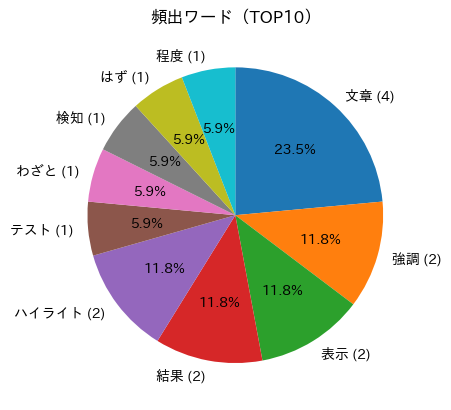

In [7]:
import japanize_matplotlib
import matplotlib.pyplot as plt
# wordの出現回数をカウントする
word_count = df['word'].value_counts()
# 出現回数を降順にソートする
top10 = word_count.head(10)
top10 = top10.sort_values(ascending=False)
# 円グラフを描く
plt.pie(top10, labels=top10.index + ' (' + top10.astype(str) + ')', autopct='%1.1f%%', startangle=90, counterclock=False)
plt.title('頻出ワード（TOP10）')
plt.show()